### Salary Predictions Based on College Attributes

##### The purpose of this project is to make accurate salary predictions that are based on existing known salaries so students can make informed decisions when making their college choice. This model will help the colleges in marketing their school to future students as a reason to attend.

##### Data transformation and machine learning will be used to create a model that will predict a salary based upon region and school type. 

##### The data for this model is relatively simplified as it has very few missing areas. The raw data consists of a dataset with the features listed above and their corresponding salaries. Twenty percent of this dataset was split into a test dataset with corresponding salaries so accuracy and error of the model can be determined.

##### The features in this data set are described as below:

##### Region: What area of the country the school is located in
##### School Type: Party, Engineering, State, Liberal Arts, or Ivy League

In [150]:
#import required libraries
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

### Data Preparation
#### Define relevant functions needed in the span of the project

In [151]:
#function to load the data into a Pandas Dataframe
def load_f(file):
    return pd.read_csv(file)

#clean the data - remove duplicates and salaries that are $0
def clean_d(original_df):
    clean_d = original_df.drop_duplicates(subset='School Name')
    clean_d = original_df[original_df.Salary>0]
    return clean_d

#distribution plots 
def dis_data(Rfunction, Bfunction, Rname, Bname, title):
    plt.figure(figsize=(10,6))
    ax1 = sns.distplot(Rfunction, hist = False, color = 'r', label = Rname)
    ax1 = sns.distplot(Bfunction, hist = False, color = 'b', label = Bname)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
    plt.title(title)
    plt.legend()
    plt.show()
    plt.close()

In [152]:
#load data
print("Loading data..")
college_df = load_f('salaries-by-college-type.csv')
region_df = load_f('salaries-by-region.csv')
major_df = load_f('degrees-that-pay-back.csv')

#define the variables
cat_vars = ['Type', 'Region']
num_vars = ['Starting Median Salary', 'Mid-Career Median Salary', 'Mid-Career 10th Percentile Salary', 'Mid-Career 75th Percentile Salary', 'Mid-Career 90th Percentile Salary', 'Percent change from Starting Salary to Mid-Career Salary']
tar = 'Starting Median Salary'

#verify data is laoded 
college_df.head()

Loading data..


,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),Engineering,"$72,200.00","$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00"
1,California Institute of Technology (CIT),Engineering,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,Engineering,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
3,"Polytechnic University of New York, Brooklyn",Engineering,"$62,400.00","$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00"
4,Cooper Union,Engineering,"$62,200.00","$114,000.00",NaN,"$80,200.00","$142,000.00",NaN


In [153]:
#verify data is loaded - 
region_df.head()

,School Name,Region,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Stanford University,California,"$70,400.00","$129,000.00","$68,400.00","$93,100.00","$184,000.00","$257,000.00"
1,California Institute of Technology (CIT),California,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,California,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
3,"University of California, Berkeley",California,"$59,900.00","$112,000.00","$59,500.00","$81,000.00","$149,000.00","$201,000.00"
4,Occidental College,California,"$51,900.00","$105,000.00",NaN,"$54,800.00","$157,000.00",NaN


#### See lengths and dtypes of the loaded data frames

In [154]:
college_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269 entries, 0 to 268
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   School Name                        269 non-null    object
 1   School Type                        269 non-null    object
 2   Starting Median Salary             269 non-null    object
 3   Mid-Career Median Salary           269 non-null    object
 4   Mid-Career 10th Percentile Salary  231 non-null    object
 5   Mid-Career 25th Percentile Salary  269 non-null    object
 6   Mid-Career 75th Percentile Salary  269 non-null    object
 7   Mid-Career 90th Percentile Salary  231 non-null    object
dtypes: object(8)
memory usage: 16.9+ KB


In [155]:
region_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 8 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   School Name                        320 non-null    object
 1   Region                             320 non-null    object
 2   Starting Median Salary             320 non-null    object
 3   Mid-Career Median Salary           320 non-null    object
 4   Mid-Career 10th Percentile Salary  273 non-null    object
 5   Mid-Career 25th Percentile Salary  320 non-null    object
 6   Mid-Career 75th Percentile Salary  320 non-null    object
 7   Mid-Career 90th Percentile Salary  273 non-null    object
dtypes: object(8)
memory usage: 20.1+ KB


#### Check the shape of the dataframes

In [156]:
#shape of the data
print(college_df.shape)
print(region_df.shape)

(269, 8)
(320, 8)


#### The data in the college_df has the Starting Median Salary, i.e the target variable along with School Name that corresponds with the School Name in the region_df. We will merge the two in a single dataframe.

In [157]:
#merge training data with features and training data with salary - store in train_df
train_df = pd.merge(college_df,region_df, on = 'School Name')

In [158]:
#verify features on merged data
train_df.head()

,School Name,School Type,Starting Median Salary_x,Mid-Career Median Salary_x,Mid-Career 10th Percentile Salary_x,Mid-Career 25th Percentile Salary_x,Mid-Career 75th Percentile Salary_x,Mid-Career 90th Percentile Salary_x,Region,Starting Median Salary_y,Mid-Career Median Salary_y,Mid-Career 10th Percentile Salary_y,Mid-Career 25th Percentile Salary_y,Mid-Career 75th Percentile Salary_y,Mid-Career 90th Percentile Salary_y
0,Massachusetts Institute of Technology (MIT),Engineering,"$72,200.00","$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00",Northeastern,"$72,200.00","$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00"
1,California Institute of Technology (CIT),Engineering,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN,California,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,Engineering,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN,California,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
3,"Polytechnic University of New York, Brooklyn",Engineering,"$62,400.00","$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00",Northeastern,"$62,400.00","$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00"
4,Cooper Union,Engineering,"$62,200.00","$114,000.00",NaN,"$80,200.00","$142,000.00",NaN,Northeastern,"$62,200.00","$114,000.00",NaN,"$80,200.00","$142,000.00",NaN


In [159]:
#verify shape of the merged data-
print(train_df.shape)

(268, 15)


#### The dataframes merged correctly as we see the shape and the features are correct.  We will now delete the unneeded columns, rename the Starting Median Salary column, and check for missing values.

In [160]:
#Remove the fields from the data set that we don't want to include in our model

del train_df['Mid-Career 10th Percentile Salary_x']
del train_df['Mid-Career 25th Percentile Salary_x']
del train_df['Mid-Career 75th Percentile Salary_x']
del train_df['Mid-Career 90th Percentile Salary_x']
del train_df['Mid-Career Median Salary_x']
del train_df['Mid-Career Median Salary_y']
del train_df['Mid-Career 10th Percentile Salary_y']
del train_df['Mid-Career 25th Percentile Salary_y']
del train_df['Mid-Career 75th Percentile Salary_y']
del train_df['Mid-Career 90th Percentile Salary_y']
del train_df['Starting Median Salary_y']

In [161]:
#Rename the Starting Median Salary Column
train_df.rename(columns = {'Starting Median Salary_x':'Salary'}, inplace=True)
train_df.rename(columns = {'School Type':'Type'}, inplace = True)

In [162]:
#verify shape of the remaining data-
print(train_df.shape)

(268, 4)


In [163]:
#store the sum of missing values in each column - 
missing_val = train_df.isnull().sum()
missing_val

School Name    0
Type           0
Salary         0
Region         0
dtype: int64

#### There are no missing values.  Now we will clean the data.

In [164]:
train_df['Salary']=(train_df['Salary'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))

In [165]:
#store the the salaries in the training data which are less than or equal to 0
zero_sal = train_df['Salary']<=0
inval = train_df[zero_sal]
inval

,School Name,Type,Salary,Region


In [166]:
#clean the data i.e, remove duplicates and remove the salaries that are invalid or not useful for predictions like salary<=0
#calling the function
clean_train_df = clean_d(train_df)

In [167]:
#Remove the fields from the data set that we don't want to include in our model
del clean_train_df['School Name']

In [168]:
print(clean_train_df.shape)

(268, 3)


In [169]:
#Reset the index values after dropping the invalid values 
clean_train_df.reset_index(drop = True)
clean_train_df.tail()

,Type,Salary,Region
263,State,37700.0,Southern
264,State,40400.0,Midwestern
265,State,41900.0,Western
266,State,37900.0,Western
267,State,35300.0,Midwestern


#### Next, we will check the data types to be sure they are appropriate for the columns.

In [170]:
print(clean_train_df.dtypes)

Type       object
Salary    float64
Region     object
dtype: object


### Exploratory Data Analysis
#### Quantitative Data Descriptive Statistics

In [171]:
clean_train_df.describe()

,Salary
count,268.000000
mean,46043.656716
std,6411.734098
min,34800.000000
25%,42000.000000
50%,44700.000000
75%,48150.000000
max,75500.000000


#### In looking at the above, the count, min, and max look correct for the salary data. The mean and standard deviation don't provide any indication that something is with the salary data.

In [172]:
#count of unique values in categorical data
for cat in cat_vars:
    if cat != 'Salary':
       print(clean_train_df[cat].value_counts())

State           175
Liberal Arts     47
Party            20
Engineering      18
Ivy League        8
Name: Type, dtype: int64
Northeastern    70
Southern        68
Midwestern      64
Western         39
California      27
Name: Region, dtype: int64


In [173]:
# unique values in clean_train_df data -
clean_train_df.nunique()

Type        5
Salary    145
Region      5
dtype: int64

In [174]:
#compute the kurtosis and skewness of salary
print('Salary Skewness:', clean_train_df['Salary'].skew())
print('Salary Kurtosis:', clean_train_df['Salary'].kurt())
print('\n')

Salary Skewness: 1.5322161789586024
Salary Kurtosis: 3.3167694686433755




#### The Salary Skewness is greater than +1, this is an indication of a substantially positively skewed distribution.  For kurtosis, the general guideline is that if the number is greater than +1, the distribution is too peaked.  Our number of 3.316 indicates a distribution that is more peaked than a normal distribution (kurtosis of 0).

### Visualize target variable (Salary)

In [175]:
#We use IQR to identify potential outliers 

stats = clean_train_df['Salary'].describe()
IQR = stats['75%'] - stats['25%']
upper_bound = stats['75%'] + 1.5 * IQR
lower_bound = stats['25%'] - 1.5 * IQR
print('The upper and lower bounds for suspected outliers are {} and {}.'.format(upper_bound, lower_bound))

The upper and lower bounds for suspected outliers are 57375.0 and 32775.0.


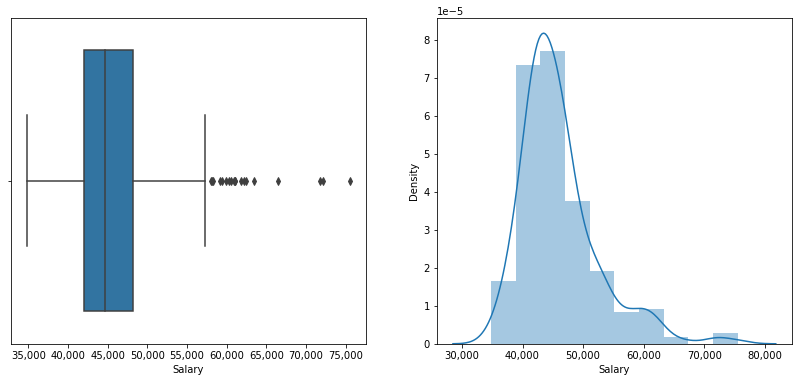

In [176]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
sns.boxplot(clean_train_df['Salary'])
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.subplot(1,2,2)
sns.distplot(clean_train_df['Salary'], bins = 10)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [177]:
# Examine the outliers below the lower bound- 
clean_train_df[clean_train_df['Salary'] < 32775.0]

,Type,Salary,Region


In [178]:
#Examine potential outliers above the upper bound - 
clean_train_df.loc[clean_train_df['Salary'] > 57375.0, 'Type'].value_counts()

Engineering    11
Ivy League      7
State           1
Name: Type, dtype: int64

In [179]:
#Examine potential outliers above the upper bound - 
clean_train_df.loc[clean_train_df['Salary'] > 57375.0, 'Region'].value_counts()

Northeastern    14
California       3
Western          1
Southern         1
Name: Region, dtype: int64

####  It looks like the outliers are all attributed to engineering school types or the northeastern region.  Engineering School Type produced the highest salaries in the data set and Ivy League Schools are located in the Northeastern Region.  This seems appropriate so we will keep the data.

### Relationships with categorical features-

####  We will visualize the categorical features to see which features could be good predictors of salary.  Below are violin plots showing the mean and interquartile ranges in addition to the shape of the distribution curve. 

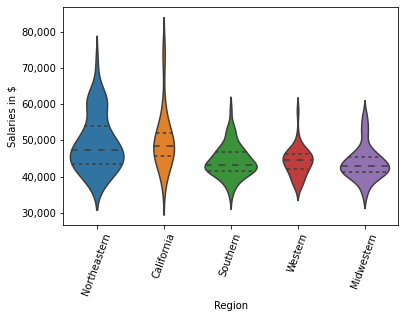

In [180]:
sns.violinplot(x = clean_train_df.Region, y = clean_train_df['Salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries in $')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

#### We can see that the California region had the highest salary, followed closely by the Northeastern region. Distributions appear normal 

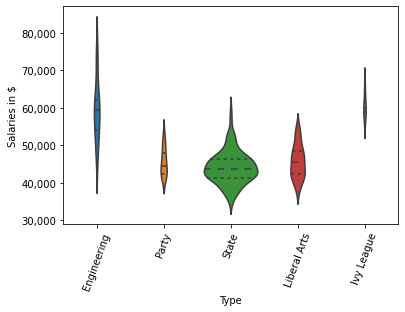

In [181]:
sns.violinplot(x = clean_train_df.Type, y = clean_train_df['Salary'], data = clean_train_df, scale = 'count', inner = 'quartile')
plt.xticks(rotation = 70)
plt.ylabel('Salaries in $')
plt.gca().yaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

#### We can see that Ivy League and Engineering are the highest starting salary school types.

## Feature Analysis - School Type

#### We will now clean the college_df and assign dummy variables to the school type categorical data using one hot enoder so it can be used in the machine learning model.

In [182]:
college_df.head()

,School Name,School Type,Starting Median Salary,Mid-Career Median Salary,Mid-Career 10th Percentile Salary,Mid-Career 25th Percentile Salary,Mid-Career 75th Percentile Salary,Mid-Career 90th Percentile Salary
0,Massachusetts Institute of Technology (MIT),Engineering,"$72,200.00","$126,000.00","$76,800.00","$99,200.00","$168,000.00","$220,000.00"
1,California Institute of Technology (CIT),Engineering,"$75,500.00","$123,000.00",NaN,"$104,000.00","$161,000.00",NaN
2,Harvey Mudd College,Engineering,"$71,800.00","$122,000.00",NaN,"$96,000.00","$180,000.00",NaN
3,"Polytechnic University of New York, Brooklyn",Engineering,"$62,400.00","$114,000.00","$66,800.00","$94,300.00","$143,000.00","$190,000.00"
4,Cooper Union,Engineering,"$62,200.00","$114,000.00",NaN,"$80,200.00","$142,000.00",NaN


In [183]:
#Remove the fields from the data set that we don't want to include in our model
del college_df['School Name']
del college_df['Mid-Career Median Salary']
del college_df['Mid-Career 10th Percentile Salary']
del college_df['Mid-Career 25th Percentile Salary']
del college_df['Mid-Career 75th Percentile Salary']
del college_df['Mid-Career 90th Percentile Salary']

In [184]:
college_df['Starting Median Salary']=(college_df['Starting Median Salary'].replace( '[\$,)]','', regex=True )
                   .replace( '[(]','-',   regex=True ).astype(float))

In [185]:
college_df.head()

,School Type,Starting Median Salary
0,Engineering,72200.0
1,Engineering,75500.0
2,Engineering,71800.0
3,Engineering,62400.0
4,Engineering,62200.0


In [186]:
#Generate our categorical variable list
college_df_cat = college_df.dtypes[college_df.dtypes == "object"].index
college_df_cat

Index(['School Type'], dtype='object')

In [187]:
#Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

#Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(college_df[college_df_cat]))

#Add the encoded variable names to the DataFrame
encode_df.columns = enc.get_feature_names(college_df_cat)
encode_df.head()

,School Type_Engineering,School Type_Ivy League,School Type_Liberal Arts,School Type_Party,School Type_State
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [188]:
#Merge one-hot encoded features and drop the originals
college_df = college_df.merge(encode_df, left_index=True, right_index=True)
college_df = college_df.drop(college_df_cat,1)
college_df.head()

,Starting Median Salary,School Type_Engineering,School Type_Ivy League,School Type_Liberal Arts,School Type_Party,School Type_State
0,72200.0,1.0,0.0,0.0,0.0,0.0
1,75500.0,1.0,0.0,0.0,0.0,0.0
2,71800.0,1.0,0.0,0.0,0.0,0.0
3,62400.0,1.0,0.0,0.0,0.0,0.0
4,62200.0,1.0,0.0,0.0,0.0,0.0


In [189]:
college_df.rename(columns = {'Starting Median Salary':'Starting_Median_Salary'}, inplace=True)

In [190]:
#Remove the target from features data
X = college_df.drop(columns=["Starting_Median_Salary"]).values
y = college_df.Starting_Median_Salary.values

In [191]:
#Split into a training set and a test set
from sklearn.model_selection import train_test_split

#training set will be the larger portion of the data, typically 70% or more
#after the split will have four sets of data: x_train, x_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [192]:
#Create Linear Regression Object and fit the model
reg = LinearRegression()
reg.fit(X_train,y_train)
reg

LinearRegression()

#### The coefficients for our model:

In [193]:
#View coeff of Linear Regression object 
print(reg.intercept_)
print(reg.coef_)

51118.15579710145
[ 8313.0942029   9761.8442029  -5505.6557971  -5643.1557971
 -6926.12681159]


#### The model (with one feature) has been created and we'll use it to predict the salaries.  We will store the predictions using the training data as variable pred_sal.

In [194]:
#predict salary using training data
pred_sal = reg.predict(X_train)

#View first five predictions -
print ('First five predictions:' , pred_sal[0:5])

First five predictions: [44192.02898551 44192.02898551 44192.02898551 45475.
 59431.25      ]


#### We will calculate the mean squared Error (MSE), accuracy, and r-squared to evaluate the base model's (one feature) performance.  This will help us determine if adding additional features or changing the modeel improved performance over the base model.

In [195]:
#print MSE - 
print ('Mean Squared Error of our prediction model is', mean_squared_error(y_train, pred_sal))

Mean Squared Error of our prediction model is 20236173.752949107


In [196]:
# accurace of the baseline model using 5-cross validation method -
score = cross_val_score(reg, X_train, y_train, cv = 5)
print ('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy 0.45934814264120033 0.10451890271426399


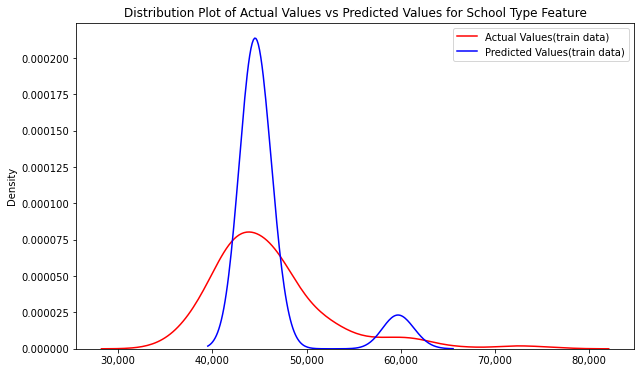

In [204]:
#distribution plot 
#Calling the function
Title = 'Distribution Plot of Actual Values vs Predicted Values for School Type Feature'
dis_data(y_train, pred_sal, 'Actual Values(train data)', 'Predicted Values(train data)', Title)

In [198]:
#store test set predictions in yhat_test 
sal_test = reg.predict(X_test)

#view first five predictions - 
print ('First five predictions(test data)', sal_test[0:5])

First five predictions(test data) [59431.25       44192.02898551 45612.5        44192.02898551
 44192.02898551]


In [199]:
#MSE of test data - 
print ('Mean Squared Error of test data ', mean_squared_error(y_test, sal_test))

Mean Squared Error of test data  21164860.340132162


In [200]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(reg, X_test, y_test, cv = 5)
print ('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.12554749909971435 0.43439221825381963


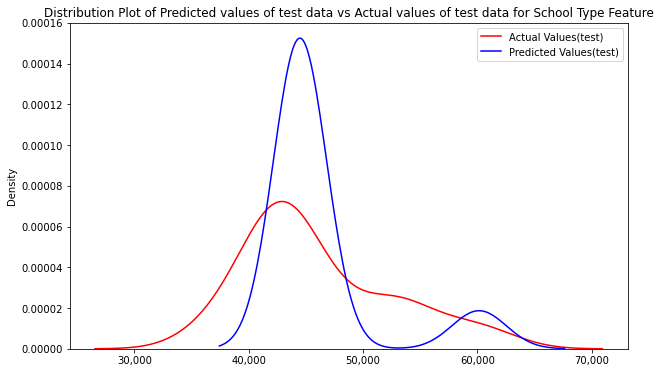

In [205]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data for School Type Feature'
dis_data(y_test, sal_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

#### We will now assign dummy variables to the categorical data ("get dummies") so it can be used in the machine learning model. 

In [104]:
## One-hot encode categorical data in clean_train_df dataset
clean_train_df = pd.get_dummies(clean_train_df)

In [105]:
clean_train_df.head()

,Salary,Type_Engineering,Type_Ivy League,Type_Liberal Arts,Type_Party,Type_State,Region_California,Region_Midwestern,Region_Northeastern,Region_Southern,Region_Western
0,72200.0,1,0,0,0,0,0,0,1,0,0
1,75500.0,1,0,0,0,0,1,0,0,0,0
2,71800.0,1,0,0,0,0,1,0,0,0,0
3,62400.0,1,0,0,0,0,0,0,1,0,0
4,62200.0,1,0,0,0,0,0,0,1,0,0


### Correlation between all the features 

#### We can now see the correlation between all features.

<AxesSubplot:>

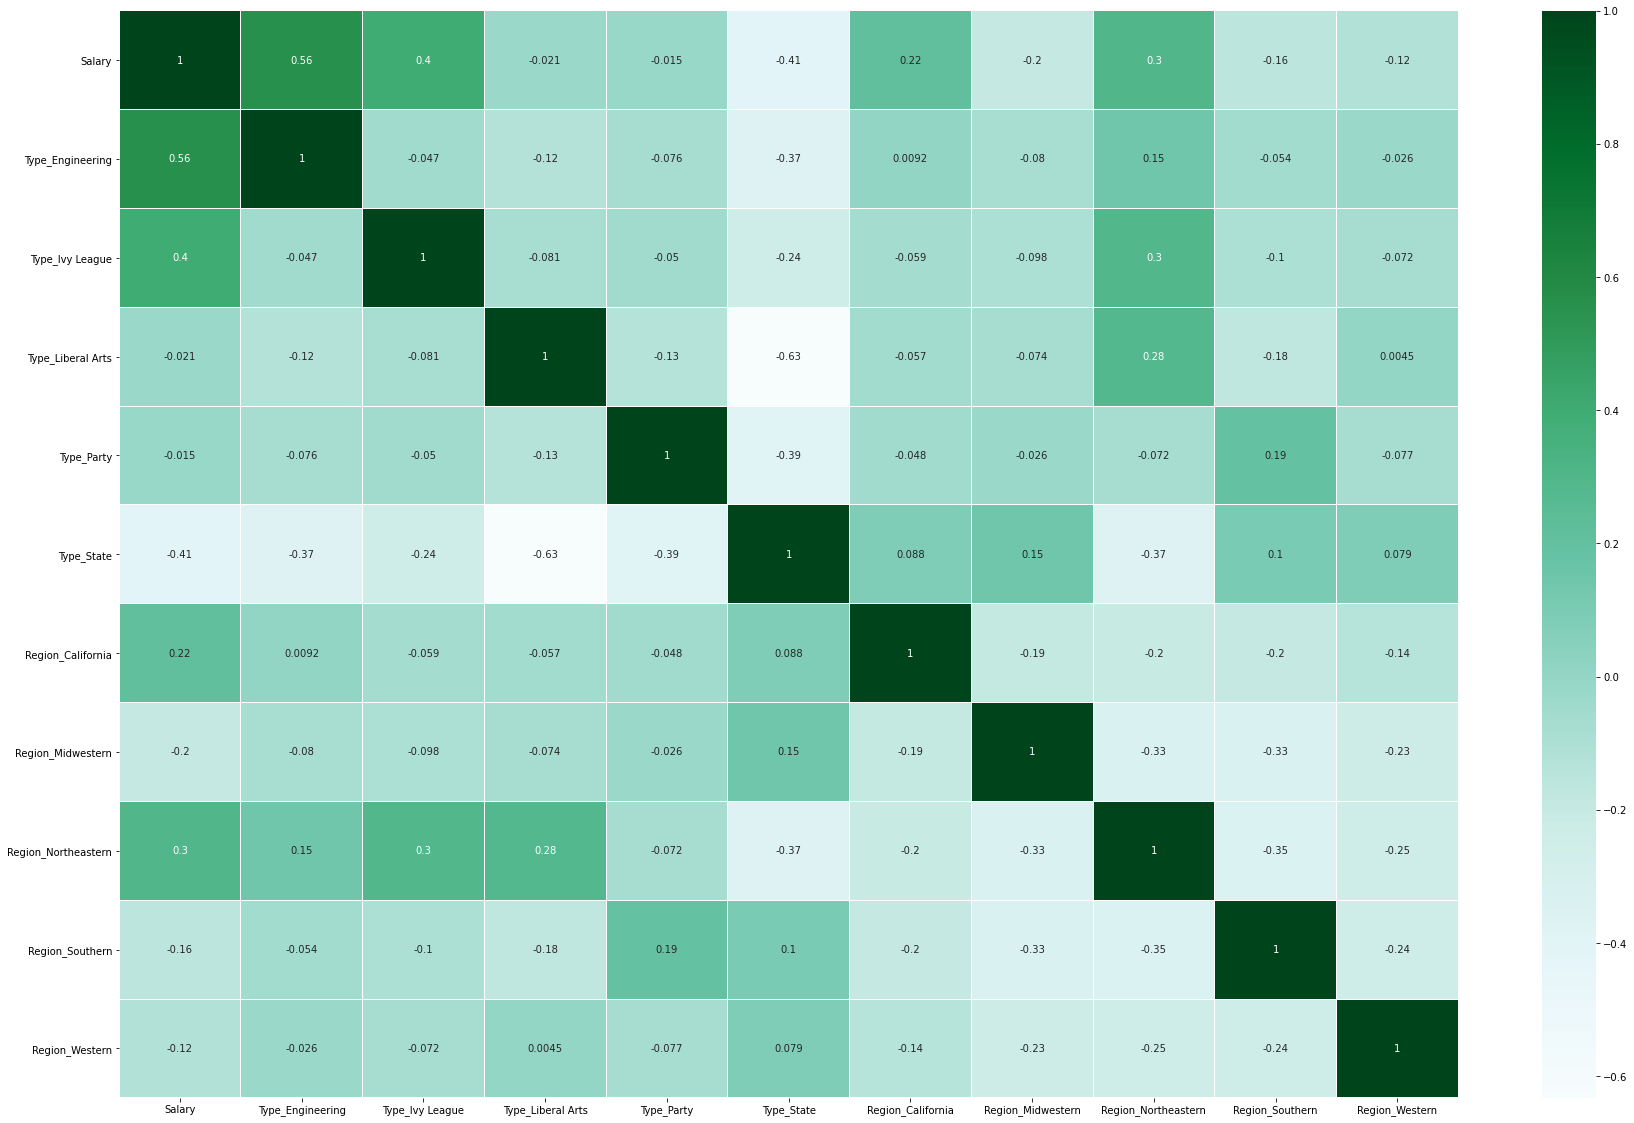

In [106]:
# Plot heatmap of all data with correlation coefficients visible
clean_train_df_corr = clean_train_df.corr()
plt.subplots(figsize=(30,20))
sns.heatmap(clean_train_df_corr, cmap = 'BuGn', linewidth =.005, annot = True)

#### Engineering School Type has the highest correlation with salary followed closely by Ivy League School Type.

#### Next we will create a basic linear regression model.  Twenty percent of the training data will be split into testing data that we can use to test the model with data for the salaries that are already known.

In [107]:
#Split the data and assign 'salary' to 'sal_df' and the rest of the features to 'feat_df'. 
feat_df = clean_train_df[clean_train_df.loc[ :, clean_train_df.columns != 'Salary'].columns]
sal_df = clean_train_df['Salary']
feat_train, feat_test, sal_train, sal_test = train_test_split(feat_df, sal_df, test_size = 0.2, random_state = 1)

In [108]:
#View inputs and outputs of training model
feat_train.head()

,Type_Engineering,Type_Ivy League,Type_Liberal Arts,Type_Party,Type_State,Region_California,Region_Midwestern,Region_Northeastern,Region_Southern,Region_Western
18,0,0,0,1,0,0,1,0,0,0
73,0,0,1,0,0,0,0,1,0,0
180,0,0,0,0,1,0,0,0,1,0
252,0,0,0,0,1,0,1,0,0,0
140,0,0,0,0,1,0,0,1,0,0


In [109]:
sal_train.head()

18     52900.0
73     47200.0
180    44500.0
252    38900.0
140    43900.0
Name: Salary, dtype: float64

####  We are using linear regression as salary is a continuous variable.  We will establish a baseline model by applying Linear Regression to feat_train, sal_train. 

In [110]:
#Create Linear Regression Object and fit the model
reg = LinearRegression()
reg.fit(feat_train,sal_train)
reg

LinearRegression()

####  Next we will show the coefficients and intercept of our model.  In linear regression, coefficients are the values that multiply the predictor values.  The sign of each coefficient indicates the direction of the relationship between a predictor variable and the response variable.  A positive sign indicates that as the predictor variable increases, the response variable also increases.  A negative sign indicates that as the predictor variable increases, the response variable decreases.  The coefficient value represents the mean change in the response given a one unit change in the predictor. For example, if a coefficient is 1.83, the mean response value increases by 1.83 for every one unit change in the predictor.

In [111]:
#View coeff of Linear Regression object 
print(reg.intercept_)
print(reg.coef_)

-7.991850944928823e+17
[1.82224276e+17 1.82224276e+17 1.82224276e+17 1.82224276e+17
 1.82224276e+17 6.16960818e+17 6.16960818e+17 6.16960818e+17
 6.16960818e+17 6.16960818e+17]


####  After creating the baseline model, we can predict the salaries.  The variable pred_sal is used to store the predictions using the training data. 

In [112]:
#predict salary using training data
pred_sal = reg.predict(feat_train)

#View first five predictions -
print ('First five predictions:' , pred_sal[0:5])

First five predictions: [45312. 46592. 43136. 43136. 44800.]


#### Mean squared error (MSE) will be evaluated along with accuracy and r-squared to evaluate the baseline model's performance and to determine if the subsequent models improve over the established baseline model. 

In [113]:
#print MSE - 
print ('Mean Squared Error of our prediction model is', mean_squared_error(sal_train, pred_sal))

Mean Squared Error of our prediction model is 18556839.028037384


#### K-Fold Cross Validation
##### Cross-validation is a procedure used to avoid overfitting and estimate the skill of the model on new data. The value for k is chosen such that each train/test group of data samples is large enough to be statistically representative of the broader dataset.  K-Fold Cross Validation is used because it ensures that every observation from the original dataset has the chance of appearing in training and test set. 

In [114]:
# accurace of the baseline model using 5-cross validation method -
score = cross_val_score(reg, feat_train, sal_train, cv = 5)
print ('5-Cross Validation accuracy', (np.mean(score)), (np.std(score)))

5-Cross Validation accuracy 0.49880374275058453 0.13815231446486412


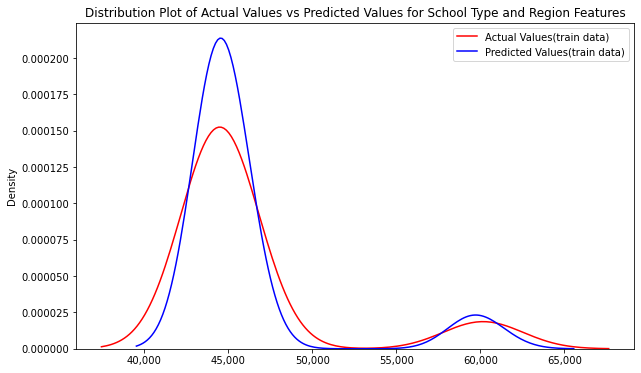

In [206]:
#distribution plot 
#Calling the function
Title = 'Distribution Plot of Actual Values vs Predicted Values for School Type and Region Features'
dis_data(sal_test, pred_sal, 'Actual Values(train data)', 'Predicted Values(train data)', Title)

#### We can see that the actual values and predicted values are  different. The range of the predicted values is lower, however, the mean doesn't look drastically different.   Next, we do the same for the 20% test data to see if the outcome is similar.

In [116]:
#store test set predictions in pred_sal_test 
pred_sal_test = reg.predict(feat_test)

#view first five predictions - 
print ('First five predictions(test data)', pred_sal_test[0:5])

First five predictions(test data) [60032. 45312. 42752. 42752. 43136.]


In [117]:
#MSE of test data - 
print ('Mean Squared Error of test data ', mean_squared_error(sal_test, pred_sal_test))

Mean Squared Error of test data  12961199.111111112


#### We can see that Mean squared error of the training data and test data differs by almost six million.

In [118]:
#accuracy of test data using 5-cross validation method - 
score = cross_val_score(reg, feat_test, sal_test, cv = 5)
print ('5-cross validation accuracy(test data)', (np.mean(score)), (np.std(score)))

5-cross validation accuracy(test data) 0.29752240225822324 0.3637386305354092


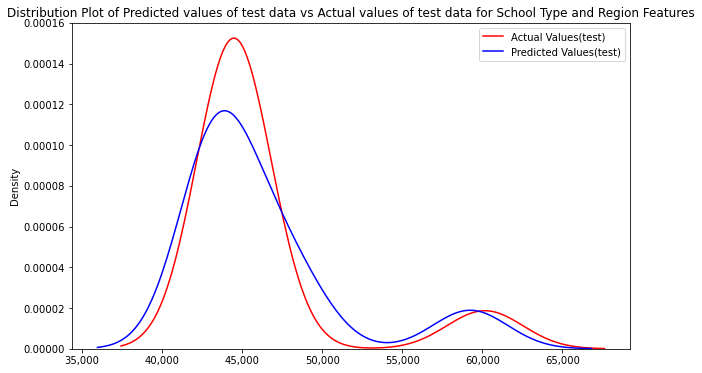

In [207]:
#Distribution plot 
Title = 'Distribution Plot of Predicted values of test data vs Actual values of test data for School Type and Region Features'
dis_data(sal_test, pred_sal_test, 'Actual Values(test)', 'Predicted Values(test)', title = Title)

####  The distribution is not very different when comparing the training data and test data.

#### We relook at the shape and features of the training and testing data before applying any changes to the multiple linear regression model. 

In [124]:
#shape and features -

print ('Number of training samples-', feat_train.shape, '\n with the features-', feat_train.columns)
print ('Number of testing samples-', feat_test.shape, '\n with the features-', feat_test.columns)
print ('Number of training salaries-', sal_train.shape)
print ('Number of testing salaries-', sal_test.shape)

Number of training samples- (214, 10) 
 with the features- Index(['Type_Engineering', 'Type_Ivy League', 'Type_Liberal Arts',
       'Type_Party', 'Type_State', 'Region_California', 'Region_Midwestern',
       'Region_Northeastern', 'Region_Southern', 'Region_Western'],
      dtype='object')
Number of testing samples- (54, 10) 
 with the features- Index(['Type_Engineering', 'Type_Ivy League', 'Type_Liberal Arts',
       'Type_Party', 'Type_State', 'Region_California', 'Region_Midwestern',
       'Region_Northeastern', 'Region_Southern', 'Region_Western'],
      dtype='object')
Number of training salaries- (214,)
Number of testing salaries- (54,)


### We applied Polynomial Features to the Multiple linear regression model to see if the MSE reduces. 

In [127]:
#Fit and transform the variables with 2nd order polynomial
pr = PolynomialFeatures(2)
feat_train_pr = pr.fit_transform(feat_train)
feat_test_pr = pr.fit_transform(feat_test)
pr

PolynomialFeatures()

In [128]:
#Create a new model using Polynomial Transformation 
poly = LinearRegression()
poly.fit(feat_train_pr, sal_train)

LinearRegression()

In [141]:
#make predictions and view first five predictions on train data - 
sal_pr = poly.predict(feat_train_pr)
print ('First five predictions(train data)-', yhat_pr[0:5])

First five predictions(train data)- [46464. 48896. 43392. 42368. 45184.]


In [142]:
#Compare first five predicted values vs actual values - 
print ('Predicted Values(train)-', sal_pr[0:5])
print ('Actual Values(train)-', sal_train[0:5].values)

Predicted Values(train)- [46464. 48896. 43392. 42368. 45184.]
Actual Values(train)- [52900. 47200. 44500. 38900. 43900.]


In [143]:
#make predictions and view first five predictions on test data - 
sal_prtest = poly.predict(feat_test_pr)
print ('First five predictions(test data)-', sal_prtest[0:5])

First five predictions(test data)- [56192. 46464. 46080. 46080. 43392.]


In [144]:
#Compare predicted values of test data and actual values of test data - 
print ('Predicted values(test)-', sal_prtest[0:5])
print ('Actual values(test)-', sal_test[0:5].values)

Predicted values(test)- [56192. 46464. 46080. 46080. 43392.]
Actual values(test)- [53000. 46300. 47100. 42400. 46500.]


In [145]:
#print R-squared values of training and testing data - 
print ('R-squared of training data-', poly.score(feat_train_pr, sal_train))
print ('R-squared of testing data-', poly.score(feat_test_pr, sal_test))

R-squared of training data- 0.2348844864538373
R-squared of testing data- 0.13362228565178458


In [146]:
#MSE of training and testing data - 
print ('MSE of training data-', mean_squared_error(sal_train, sal_pr))
print ('MSE of testing data-', mean_squared_error(sal_test, sal_prtest))

MSE of training data- 31840277.08411215
MSE of testing data- 33004311.407407407


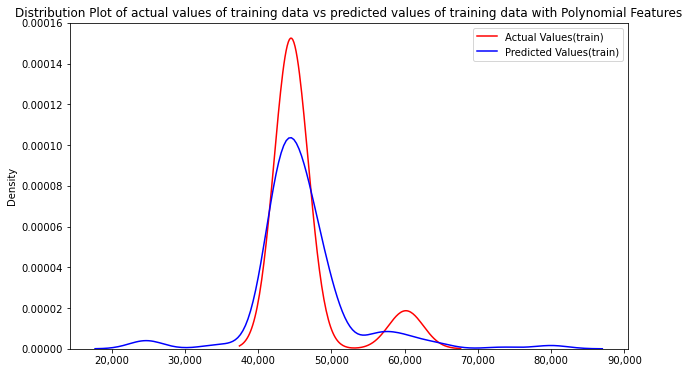

In [208]:
#View distribution plot of actual vs fitted of training data - 
dis_data(sal_test, sal_pr, 'Actual Values(train)', 'Predicted Values(train)', title = 'Distribution Plot of actual values of training data vs predicted values of training data with Polynomial Features')

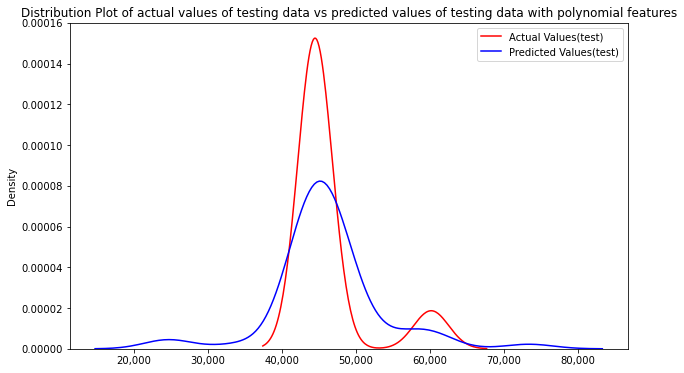

In [209]:
#view distribution plot of actual vs fitted of testing data - 
dis_data(sal_test, sal_prtest, 'Actual Values(test)', 'Predicted Values(test)', title = 'Distribution Plot of actual values of testing data vs predicted values of testing data with polynomial features')